# 네이버 쇼핑 리뷰 감성 분류

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [ ]:
# mecab 설치

!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

In [ ]:
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f0d5bea6a50>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings','reviews'])    #column name 추가
print('전체 리뷰 개수: ', len(total_data))

전체 리뷰 개수:  200000


In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## train, test dataset 분리

In [ ]:
# 평점 4,5인 리뷰에는 레이블 1 / 평점 1,2인 리뷰에는 레이블 0
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복 제외 샘플 수 확인
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# 중복 샘플 제거

total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수', len(total_data))

총 샘플의 수 199908


In [ ]:
# null값 유무 확인

print(total_data.isnull().values.any())

False


In [ ]:
# 3:! 비율로 train, test 나누기

train_data, test_data = train_test_split(total_data, test_size=.25, random_state=42)
print('훈련 리뷰 수 :', len(train_data))
print('테스트 리뷰 수 :', len(test_data))

훈련 리뷰 수 : 149931
테스트 리뷰 수 : 49977


### 레이블 분포 확인

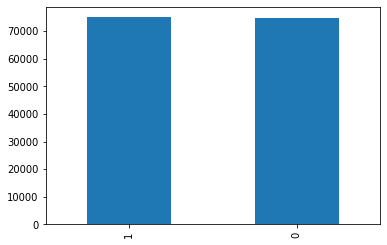

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


## 데이터 정제

#### 정규표현식

In [ ]:
# 한글과 공백만 남기기 / 빈 샘플 체크

train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# test data에도 같은 작업 수행

test_data.drop_duplicates(subset=['reviews'], inplace=True) 
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace("",np.nan,inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플 수: ', len(test_data))

전처리 후 테스트용 샘플 수:  49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


#### 토큰화

In [ ]:
mecab = Mecab()
stopwords = ['엇', '주', '겠', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [s for s in x if s not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['reviews'].apply(lambda x: [s for s in x if s not in stopwords])

#### 단어와 길이 분포 확인

In [ ]:
negative_words = np.hstack(train_data[train_data.label==0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label==1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰 평균 길이:  13.477277271939531
부정 리뷰의 평균 길이 : 16.88148375557276


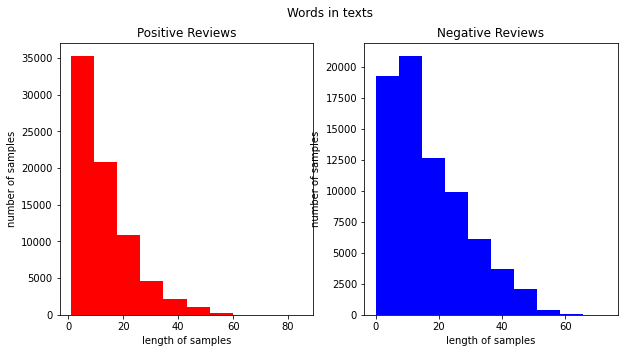

In [ ]:
# 길이 분포 확인

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x:len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰 평균 길이: ', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x:len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))

plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

#### 정수 인코딩

In [ ]:
# 훈련 데이터에 대해 단어 집합 만들기

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
tokenizer.word_index

In [ ]:
threshold=2
total_cnt = len(tokenizer.word_index) #vocab수
rare_cnt=0  #등장빈도 threshold 미만인 단어 수 카운트
total_freq =0   #훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0   #등장빈도 threshold 미만인 단어의 등장 빈도수 총합

for key, value in tokenizer.word_counts.items():
    total_freq += value

    if (value < threshold):
        rare_cnt += 1
        rare_freq += value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 39995
등장빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53819227403426
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8003258780382987


In [ ]:
# 전체 단어 중 등장 빈도 2 미만인 단어 제거할 것
vocab_size = total_cnt - rare_cnt + 2 #0번 패딩 토큰, OOV토큰 고려해서 +2
print("단어 집합 크기:", vocab_size)

단어 집합 크기: 21784


In [ ]:
'''토크나이저로 텍스트 시퀀스를 숫자 시퀀스로 변환
   정수 인코딩에서 이보다 큰 숫자 부여된 단어는 OOV로 변환'''

tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])
print(X_test[:3])

[[65, 2057, 297, 14256, 261, 71, 6, 234, 166, 135, 802, 2948, 623, 2, 75, 60, 205, 38, 1340, 153, 3, 6], [480, 407, 50, 8527, 2558, 2514, 337, 2915, 248, 2354, 471, 2], [44, 24, 822, 103, 35, 2369, 158, 7, 10, 8058, 4, 1316, 29, 138, 320, 39, 57, 158, 138, 7, 1913, 2, 111, 160, 1376, 321, 117, 134]]
[[718, 579, 1, 701, 1, 764, 1, 114, 1, 432, 1829, 520, 3513, 1932, 57], [953, 988, 1, 1, 1299, 1, 111, 1, 638, 54, 22], [408, 3324, 1, 1271, 2076, 22, 1, 5415, 288, 132, 1, 3, 27, 1, 15, 28, 22, 1, 511, 1, 447, 17, 33, 1, 616, 1339, 1, 33, 57, 1, 7, 1, 22]]


#### 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞처주기 위한 것

In [ ]:
print("리뷰 최대 길이: ", max(len(l) for l in X_train))
print("리뷰 평균 길이: ", sum(map(len, X_train))/len(X_train))

리뷰 최대 길이:  85
리뷰 평균 길이:  15.178302018928708


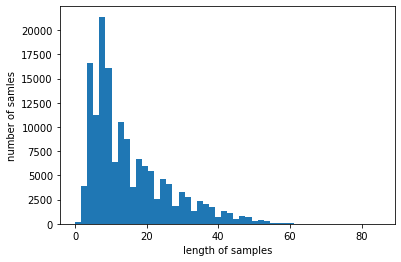

In [ ]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samles')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt=0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt += 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s" %(max_len, (cnt/len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
# 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 모델1 : RNN 감성분류

In [ ]:
from keras.layers import Embedding, Dense, GRU, LSTM, SimpleRNN
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim= vocab_size,output_dim= 100))
rnn_model.add(SimpleRNN(32)) # 노드 32
rnn_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('r_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = rnn_model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=60, validation_split=.2)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2905 - acc: 0.8881
Epoch 1: val_acc improved from -inf to 0.90816, saving model to r_best_model.h5
2000/2000 [==============================] - 82s 40ms/step - loss: 0.2905 - acc: 0.8881 - val_loss: 0.2490 - val_acc: 0.9082
Epoch 2/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2410 - acc: 0.9121
Epoch 2: val_acc improved from 0.90816 to 0.91353, saving model to r_best_model.h5
2000/2000 [==============================] - 79s 40ms/step - loss: 0.2410 - acc: 0.9121 - val_loss: 0.2384 - val_acc: 0.9135
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2223 - acc: 0.9203
Epoch 3: val_acc did not improve from 0.91353
2000/2000 [==============================] - 78s 39ms/step - loss: 0.2223 - acc: 0.9203 - val_loss: 0.2438 - val_acc: 0.9084
Epoch 4/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2076 - acc: 0.9268
Epoch 4: val_acc did not improve from 0.9135

In [ ]:
loaded_model = load_model('r_best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 11s 7ms/step - loss: 0.6327 - acc: 0.7270

 테스트 정확도: 0.7270


## 모델2 : GRU로 감성분류

In [ ]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim= vocab_size,output_dim= 100))
gru_model.add(GRU(32))
gru_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = gru_model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=60, validation_split=.2)

Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2745 - acc: 0.8963
Epoch 1: val_acc improved from -inf to 0.91373, saving model to best_model.h5
2000/2000 [==============================] - 145s 71ms/step - loss: 0.2745 - acc: 0.8963 - val_loss: 0.2336 - val_acc: 0.9137
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2187 - acc: 0.9210
Epoch 2: val_acc improved from 0.91373 to 0.91937, saving model to best_model.h5
2000/2000 [==============================] - 138s 69ms/step - loss: 0.2187 - acc: 0.9210 - val_loss: 0.2204 - val_acc: 0.9194
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2018 - acc: 0.9279
Epoch 3: val_acc improved from 0.91937 to 0.92707, saving model to best_model.h5
2000/2000 [==============================] - 147s 74ms/step - loss: 0.2018 - acc: 0.9279 - val_loss: 0.2078 - val_acc: 0.9271
Epoch 4/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.1914 - acc: 0.9323
Epoch 4: v

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 17s 10ms/step - loss: 0.4333 - acc: 0.8106

 테스트 정확도: 0.8106


## 모델3 : LSTM 감성분류

In [ ]:
l_model = Sequential()
l_model.add(Embedding(input_dim= vocab_size,output_dim= 100))
l_model.add(LSTM(32)) # 노드 32
l_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('l_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

l_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = l_model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=60, validation_split=.2)

Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2752 - acc: 0.8962
Epoch 1: val_acc improved from -inf to 0.91610, saving model to l_best_model.h5
2000/2000 [==============================] - 144s 70ms/step - loss: 0.2752 - acc: 0.8962 - val_loss: 0.2316 - val_acc: 0.9161
Epoch 2/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2202 - acc: 0.9209
Epoch 2: val_acc improved from 0.91610 to 0.92143, saving model to l_best_model.h5
2000/2000 [==============================] - 139s 69ms/step - loss: 0.2202 - acc: 0.9209 - val_loss: 0.2163 - val_acc: 0.9214
Epoch 3/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2027 - acc: 0.9275
Epoch 3: val_acc improved from 0.92143 to 0.92563, saving model to l_best_model.h5
2000/2000 [==============================] - 138s 69ms/step - loss: 0.2027 - acc: 0.9275 - val_loss: 0.2063 - val_acc: 0.9256
Epoch 4/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.1921 - acc: 0.9319
Epoc

In [ ]:
loaded_model = load_model('l_best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 18s 11ms/step - loss: 0.4367 - acc: 0.8098

 테스트 정확도: 0.8098


## 모델4 : 모형 반복

In [ ]:
gru2_model = Sequential()
gru2_model.add(Embedding(input_dim= vocab_size,output_dim= 100))
gru2_model.add(GRU(32, dropout = 0.3, return_sequences = True))
gru2_model.add(GRU(64, dropout = 0.5))
gru2_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('2best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

gru2_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = gru2_model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=60, validation_split=.2)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2854 - acc: 0.8904
Epoch 1: val_acc improved from -inf to 0.90466, saving model to 2best_model.h5
2000/2000 [==============================] - 472s 233ms/step - loss: 0.2854 - acc: 0.8904 - val_loss: 0.2523 - val_acc: 0.9047
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2292 - acc: 0.9180
Epoch 2: val_acc improved from 0.90466 to 0.92193, saving model to 2best_model.h5
2000/2000 [==============================] - 467s 233ms/step - loss: 0.2292 - acc: 0.9180 - val_loss: 0.2192 - val_acc: 0.9219
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2135 - acc: 0.9237
Epoch 3: val_acc improved from 0.92193 to 0.92337, saving model to 2best_model.h5
2000/2000 [==============================] - 464s 232ms/step - loss: 0.2135 - acc: 0.9237 - val_loss: 0.2137 - val_acc: 0.9234
Epoch 4/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2061 - acc: 0.9266
Epoc

In [ ]:
loaded_model = load_model('2best_model.h5')
print("\n 테스트 정확도: %.4f" %(loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 37s 23ms/step - loss: 0.3976 - acc: 0.8328

 테스트 정확도: 0.8328


## 리뷰 예측

In [ ]:
def sentiment_predict(new_sent):
    new_sent = mecab.morphs(new_sent) #토큰화
    new_sent = [w for w in new_sent if not w in stopwords]  #불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sent])  #정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len)  #패딩
    score = float(loaded_model.predict(pad_new))    #예측 모델

    if (score>.5):
        print("{:.2f}%확률로 긍정 리뷰입니다. ".format(score*100))
    else:
        print("{:.2f}%확률로 부정 리뷰입니다. ".format((1-score)*100))

In [ ]:
sentiment_predict("또 사고 싶어요. 추천해요")

97.75%확률로 긍정 리뷰입니다. 


In [ ]:
sentiment_predict("너무 별로에요 이걸 누가 사요")

99.63%확률로 부정 리뷰입니다. 


In [ ]:
sentiment_predict("리뷰 쓸 가치도 없어요")

94.58%확률로 부정 리뷰입니다. 
